In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## EDA
Load the data.

Look at the median_house_value variable. Does it have a long tail?

In [312]:
df = pd.read_csv('housing.csv')
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='median_house_value', ylabel='Count'>

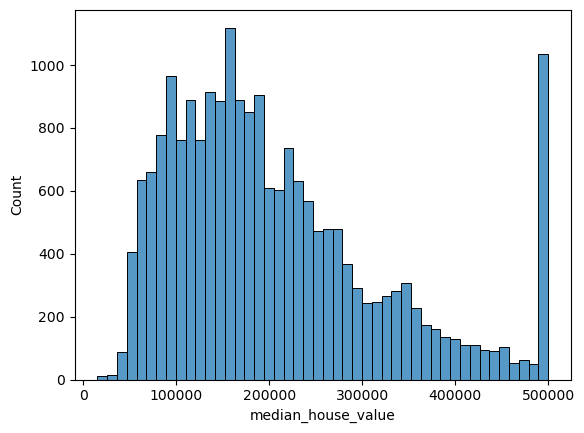

In [313]:
sns.histplot(df['median_house_value'])

## Preparing the dataset
For this homework, we only want to use a subset of data.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Next, use only the following columns:

'latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value'

In [314]:
filtered_ocean = df[df['ocean_proximity'].isin(['<1H OCEAN','INLAND'])]
selected_columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
filtered = filtered_ocean[selected_columns]
filtered.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Question 1: There's one feature with missing values. What is it?

In [315]:
filtered.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2: What's the median (50% percentile) for variable 'population'?

In [316]:
filtered['population'].describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

## Prepare and split the dataset
Shuffle the dataset (the filtered one you created above), use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [317]:
np.random.seed(42)

data_len = len(filtered)

val = int(data_len*0.2)
test = int(data_len*0.2)
train = data_len -(val+test)

idx = np.arange(data_len)
np.random.shuffle(idx)

df_shuffled = filtered.iloc[idx]

df_train= df_shuffled.iloc[:train].copy()
df_val = df_shuffled.iloc[train:train+val].copy()
df_test = df_shuffled.iloc[train+val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [318]:
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)


In [319]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [320]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    w0 = w_full[0]
    w = w_full[1:]
    return w0,w

<Axes: ylabel='Count'>

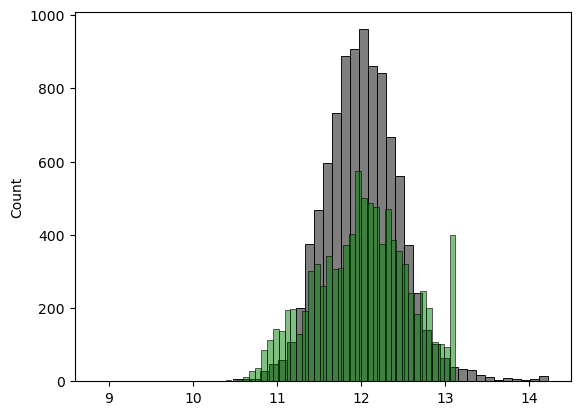

In [321]:
X_zero_train = df_train.fillna(0).values
w0, w = train_linear_regression(X_zero_train,y_train)

y_pred = w0 + X_zero_train.dot(w)

sns.histplot(y_pred, color='black', alpha=0.5, bins=50)
sns.histplot(y_train, color = 'green', alpha=0.5, bins=50)


In [322]:
def rmse(y,y_pred):
    error = (y-y_pred)**2
    mse = error.mean()
    return np.sqrt(mse)

In [323]:
rmse(y_train, y_pred).round(2,)

0.34

## Question 3: Which option gives better RMSE?

### Validation by filling missing values with 0

In [324]:
X_zero_train = df_train.fillna(0).values
w0, w = train_linear_regression(X_zero_train,y_train)

X_zero_val = df_val.fillna(0).values
y_pred = w0 + X_zero_val.dot(w)

rmse(y_val,y_pred).round(2,)

0.34

### Validation by filling missing values with mean

In [325]:
tb_mean = df_train['total_bedrooms'].mean()
tb_mean

542.552956325786

In [326]:
X_mean_train = df_train.fillna(tb_mean).values
w0, w = train_linear_regression(X_mean_train,y_train)

X_mean_val = df_val.fillna(tb_mean).values
y_pred = w0 + X_mean_val.dot(w)

rmse(y_val,y_pred).round(2,)

0.34

_Both are equally good_

## Question 4: Regularization. Which r gives the best RMSE?

In [327]:
def train_linear_regression_regularized(X,y,r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    w0 = w_full[0]
    w = w_full[1:]
    return w0,w

In [328]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = df_train.fillna(0).values
    w0, w = train_linear_regression_regularized(X_train,y_train,r)

    X_val = df_val.fillna(0).values
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val,y_pred).round(2,)
    print(r, w0, score)

0 -9.763249478052225 0.34
1e-06 -9.763228830851833 0.34
0.0001 -9.761185235851151 0.34
0.001 -9.742646249818254 0.34
0.01 -9.561056192964566 0.34
0.1 -8.058889769570351 0.34
1 -3.1331542783778734 0.34
5 -0.8410867974609664 0.35
10 -0.4381172316101039 0.35


_the smallest is 0_

## Question 5: Shuffling. What's the value of std?

In [329]:
rmse_scores =[]

for n in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(n)

    data_len = len(filtered)

    val = int(data_len*0.2)
    test = int(data_len*0.2)
    train = data_len -(val+test)

    idx = np.arange(data_len)
    np.random.shuffle(idx)

    df_shuffled = filtered.iloc[idx]

    df_train= df_shuffled.iloc[:train].copy()
    df_val = df_shuffled.iloc[train:train+val].copy()
    df_test = df_shuffled.iloc[train+val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    orig_y_train = df_train['median_house_value'].values
    orig_y_val = df_val['median_house_value'].values
    orig_y_test = df_test['median_house_value'].values
    
    y_train = np.log1p(orig_y_train)
    y_val = np.log1p(orig_y_val)
    y_test = np.log1p(orig_y_test)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_zero_train = df_train.fillna(0).values
    w0, w = train_linear_regression(X_zero_train,y_train)

    X_zero_val = df_val.fillna(0).values
    y_pred = w0 + X_zero_val.dot(w)

    score = rmse(y_val,y_pred)
    
    rmse_scores.append(score)
    
    print(r, w0, score)
    
    

10 -9.870068970994627 0.3377387160082512
10 -9.114011209926476 0.3377999353662671
10 -9.911560201090367 0.33842870067715325
10 -10.23318368166725 0.33200494683064413
10 -9.174763450323402 0.3394451862555799
10 -10.006648303751325 0.3433819705287994
10 -10.039903099714731 0.3385330211770828
10 -10.353545444809376 0.34687476972931436
10 -9.89941616712748 0.3512736865968845
10 -9.964622125939913 0.33415582665298454


calculate the std

In [330]:
np.std(rmse_scores).round(3,)

0.005

## Question 6: RMSE on Test

In [331]:
n = 9
r = 0.001
np.random.seed(n)

data_len = len(filtered)

val = int(data_len*0.2)
test = int(data_len*0.2)
train = data_len -(val+test)

idx = np.arange(data_len)
np.random.shuffle(idx)

df_shuffled = filtered.iloc[idx]

df_train= df_shuffled.iloc[:train].copy()
df_val = df_shuffled.iloc[train:train+val].copy()
df_test = df_shuffled.iloc[train+val:].copy()

df_full_train = pd.concat([df_train,df_val])

df_full_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

orig_y_df_full_train = df_full_train['median_house_value'].values
orig_y_test = df_test['median_house_value'].values

y_df_full_train = np.log1p(orig_y_df_full_train)
y_test = np.log1p(orig_y_test)

del df_full_train['median_house_value']
del df_test['median_house_value']

X_zero_train = df_full_train.fillna(0).values
w0, w = train_linear_regression_regularized(X_zero_train,y_df_full_train,r)

X_zero_test = df_test.fillna(0).values
y_pred = w0 + X_zero_test.dot(w)

score = rmse(y_test,y_pred).round(2,)
score


0.33